In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torchvision import transforms as tfm
from sklearn import metrics as skmet
import matplotlib.pyplot as plt
import json
import transforms as my_transforms

%aimport dataset
%aimport models
VideoClassifier = models.VideoClassifier
VideoData = dataset.VideoData

In [3]:
# artifact_folder = '/zfs/wficai/pda/model_run_artifacts/aihub_results_SAVE/'
artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_no2d_224x224'
# artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_all_224x224'

with open(artifact_folder + '/config_video.json', 'r') as f: 
    cfg = json.load(f)

# put all config variables in scope to avoid the need to laboriously index cfg
for k, v in cfg.items():
    v = f"'{v}'" if type(v)==str else v
    exec(f"{k}={v}")

In [4]:
# optionally override the view/mode filters
bs_test = 4
num_workers = 2
device = torch.device('cuda:0')
view_filter = ['pdaView', 'pdaRelatedView']
mode_filter = ['color', 'color_compare']

In [5]:
tfms = my_transforms.VideoTransforms(res)
tfms_test = tfms.get_transforms(transforms['test'])

In [6]:
df_train = pd.read_csv(f'{artifact_folder}/{out_paths["train"]}')
d_train = VideoData(df_train, transforms = tfms_test, mode_filter = mode_filter, view_filter = view_filter)
df_test = pd.read_csv(f'{artifact_folder}/{out_paths["test"]}')
d_test = VideoData(df_test, transforms = tfms_test, mode_filter = mode_filter, view_filter = view_filter)
dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers, collate_fn = VideoData.collate)

print("Number of frames after filtering:", len(d_test.data))

Number of frames after filtering: 11046


# Counts 

In [7]:
df = pd.concat([d_test.data, d_train.data])

### number of patients

In [8]:
df.patient_id.nunique()

57

In [9]:
train_pids_nopda = df_train.query('patient_type=="nopda"').patient_id.unique().tolist()
train_pids_pda = df_train.query('patient_type=="pda"').patient_id.unique().tolist()
train_pids_both = set(train_pids_nopda).intersection(set(train_pids_pda))
len(train_pids_nopda), len(train_pids_pda), len(train_pids_both)

(27, 20, 5)

In [10]:
len(set(df_train.patient_id.unique().tolist()).union(set(df_test.patient_id.unique().tolist())))

57

In [11]:
test_pids_nopda = df_test.query('patient_type=="nopda"').patient_id.unique().tolist()
test_pids_pda = df_test.query('patient_type=="pda"').patient_id.unique().tolist()
test_pids_both = set(test_pids_nopda).intersection(set(test_pids_pda))
len(test_pids_nopda), len(test_pids_pda), len(test_pids_both)

(12, 5, 2)

### number of clips

In [12]:
# in total
num_strata = df.groupby(['patient_type', 'external_id'], as_index=False).size().value_counts('patient_type')
display(num_strata)
print(num_strata.sum())

display(num_strata / num_strata.sum())

patient_type
pda      321
nopda    236
dtype: int64

557


patient_type
pda      0.576302
nopda    0.423698
dtype: float64

In [13]:
# in training
num_strata = d_train.data.groupby(['patient_type', 'external_id'], as_index=False).size().value_counts('patient_type')
display(num_strata)
print(num_strata.sum())

display(num_strata / num_strata.sum())

patient_type
pda      290
nopda    164
dtype: int64

454


patient_type
pda      0.638767
nopda    0.361233
dtype: float64

In [14]:
# in test
num_strata = d_test.data.groupby(['patient_type', 'external_id'], as_index=False).size().value_counts('patient_type')
display(num_strata)
print(num_strata.sum())

display(num_strata / num_strata.sum())

patient_type
nopda    72
pda      31
dtype: int64

103


patient_type
nopda    0.699029
pda      0.300971
dtype: float64

# Performance

In [28]:
# create frame model
m_frames = timm.create_model(model, num_classes=num_classes, in_chans=3, drop_rate=dropout)
_ = m_frames.to(device)

# create video model
m = VideoClassifier(m_frames, prod_expert=True)

# load checkpoint
m.load_state_dict(torch.load(f"{artifact_folder}/model_checkpoint_video.ckpt"))

<All keys matched successfully>

In [29]:
# example of getting frame classifications
m_frames_trained = m.get_frame_classifier()

In [30]:
loss_function = torch.functional.F.binary_cross_entropy_with_logits

target_ls = []
output_ls = []
study_ls = []
mask_ls = []
externalid_ls = []
view_ls = []
mode_ls = []
losses = []
attn_ls = []

for ix, batch in enumerate(dl_test):
    print(f"Batch {ix+1}", end = "\r")
    vid = batch['video'].to(device)
    mask = batch['mask'].to(device)
    targets = batch['trg_type'].to(device).type(torch.float32)
    
    target_ls.append(targets.cpu().numpy())
    view_ls.append(batch['trg_view'].numpy())
    mode_ls.append(batch['trg_mode'].numpy())
    study_ls += batch['study']
    mask_ls.append(batch['mask'].numpy())
    externalid_ls += batch['external_id']

    with torch.no_grad():
        outputs, attn = m(vid, mask)
        output_ls.append(outputs.cpu().numpy())
        attn_ls.append(attn.cpu().numpy())
        loss = loss_function(outputs, targets)
        losses.append(loss.detach().item())

In [31]:
df_results = pd.DataFrame(dict(
    study = study_ls,
    external_id = externalid_ls,
    predicted = np.concatenate(output_ls).squeeze(),
    target = np.concatenate(target_ls), 
    mode = np.concatenate(mode_ls),
    view = np.concatenate(view_ls)
))

df_results['mode'] = df_results['mode'].map(VideoData.inv_mode_map)
df_results.view = df_results.view.map(VideoData.inv_view_map)

df_results.head(20)

,study,external_id,predicted,target,mode,view
0,study24,study24_dicom98,0.001858,0.0,color_compare,pdaRelatedView
1,study24,study24_dicom117,0.006257,0.0,color,pdaView
2,study24,study24_dicom110,0.007584,0.0,color_compare,pdaRelatedView
3,study18,study18_dicom63,0.241542,0.0,color_compare,pdaRelatedView
4,study18,study18_dicom41,0.044291,0.0,color,pdaRelatedView
5,study30,study30_dicom77,0.150368,0.0,color_compare,pdaRelatedView
6,study30,study30_dicom66,0.034186,0.0,color_compare,pdaRelatedView
7,study62,study62_dicom54,0.326956,0.0,color_compare,pdaRelatedView
8,study62,study62_dicom34,0.030951,0.0,color,pdaRelatedView
9,study62,study62_dicom58,0.132728,0.0,color_compare,pdaView


In [32]:
def compute_metrics(y_true, y_pred, thresh=0.5):
    mets = dict()
    
    y_pred_cls = (y_pred>thresh).astype(int)
    
    mets['num_samples'] = len(y_true)
    mets['roc_auc'] = skmet.roc_auc_score(y_true, y_pred)
    mets['average_precision'] = skmet.average_precision_score(y_true, y_pred)
    mets['accuracy'] = skmet.accuracy_score(y_true, y_pred_cls)
    mets['sensitivity'] = skmet.recall_score(y_true, y_pred_cls)
    mets['specificity'] = skmet.recall_score(y_true, y_pred_cls, pos_label=0)
    
    return mets

# Clip-level results

In [33]:
compute_metrics(df_results.target, df_results.predicted)

{'num_samples': 103,
 'roc_auc': 0.9274193548387097,
 'average_precision': 0.9379338790873211,
 'accuracy': 0.9514563106796117,
 'sensitivity': 0.8709677419354839,
 'specificity': 0.9861111111111112}

In [34]:
grouped_results = df_results.groupby(['view', 'mode']).apply(lambda dat: compute_metrics(dat.target, dat.predicted))
grouped_results = pd.DataFrame(grouped_results.tolist(), index=grouped_results.index)
grouped_results

num_samples   roc_auc  average_precision  \
view           mode                                                      
pdaRelatedView color                   21  0.666667           0.714286   
               color_compare           31  0.972826           0.951923   
pdaView        color                   18  1.000000           1.000000   
               color_compare           33  0.929630           0.959192   

                              accuracy  sensitivity  specificity  
view           mode                                               
pdaRelatedView color          0.952381     0.666667     1.000000  
               color_compare  0.967742     0.875000     1.000000  
pdaView        color          0.944444     1.000000     0.923077  
               color_compare  0.939394     0.866667     1.000000

# ROC Curve

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

In [36]:
# scores for full set
fpr, tpr, _ = roc_curve(df_results.target, df_results.predicted)
auc = roc_auc_score(df_results.target, df_results.predicted)

In [37]:
# scores for pda view
df_results_pda = df_results.query('view=="pdaView"')
fpr_pda, tpr_pda, _ = roc_curve(df_results_pda.target, df_results_pda.predicted)
auc_pda= roc_auc_score(df_results_pda.target, df_results_pda.predicted)

In [38]:
# scores for pda-related view
df_results_pdarel = df_results.query('view=="pdaRelatedView"')
fpr_pdarel, tpr_pdarel, _ = roc_curve(df_results_pdarel.target, df_results_pdarel.predicted)
auc_pdarel = roc_auc_score(df_results_pdarel.target, df_results_pdarel.predicted)

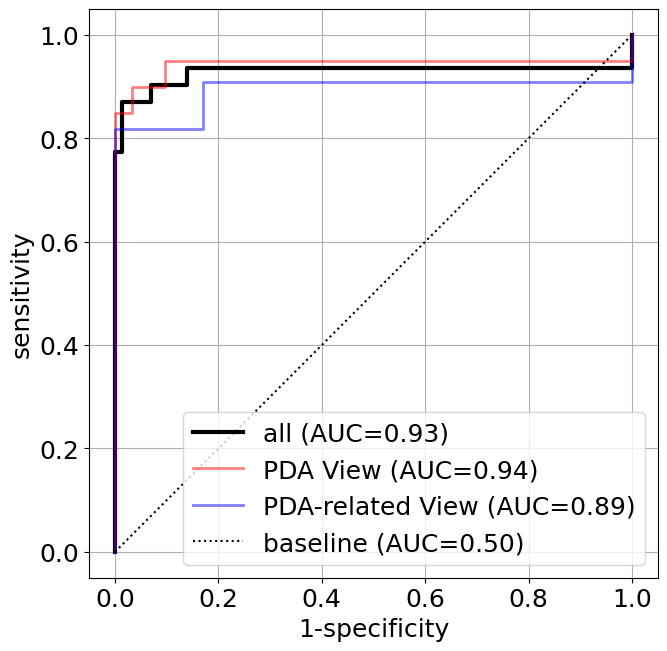

In [39]:
plt.rcParams['font.size'] = 18
plt.gcf().set_size_inches(7,7)
plt.plot(fpr, tpr, 'k', label=f'all (AUC={auc:0.2f})', linewidth=3)
plt.plot(fpr_pda, tpr_pda, 'r', label=f'PDA View (AUC={auc_pda:0.2f})', linewidth=2, alpha=0.5)
plt.plot(fpr_pdarel, tpr_pdarel, 'b', label=f'PDA-related View (AUC={auc_pdarel:0.2f})', linewidth=2, alpha=0.5)
plt.plot(fpr, fpr, 'k:', label='baseline (AUC=0.50)')
plt.grid()
plt.gca().set_aspect(1)
plt.xlabel("1-specificity")
plt.ylabel("sensitivity")
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('roc_auc_curve_videos.png', dpi=500)

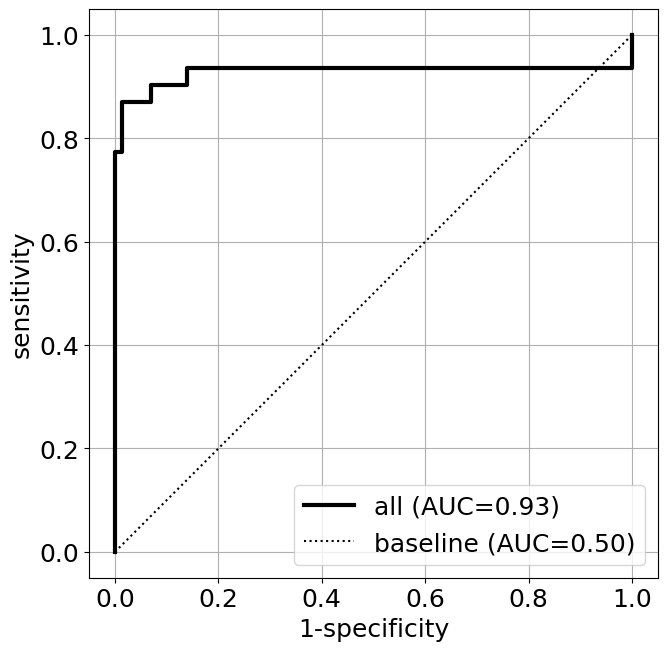

In [40]:
plt.rcParams['font.size'] = 18
plt.gcf().set_size_inches(7,7)
plt.plot(fpr, tpr, 'k', label=f'all (AUC={auc:0.2f})', linewidth=3)
plt.plot(fpr, fpr, 'k:', label='baseline (AUC=0.50)')
plt.grid()
plt.gca().set_aspect(1)
plt.xlabel("1-specificity")
plt.ylabel("sensitivity")
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('roc_auc_curve_videos_all.png', dpi=500)